https://github.com/NanoComp/meep/blob/master/python/examples/straight-waveguide.ipynb  

https://stackoverflow.com/questions/29454002/filenotfounderror-errno-2-no-such-file-or-directory-ffmpeg


In [1]:
import math
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Using MPI version 3.1, 1 processes


In [3]:
def phc_trans(PhC = True, lengthPhC = 100, decay_check=0, T_decay=500):
    """
    <変数の説明>
    PhC...PhC(フォトニック決勝)を配置するかどうか。Falseで直線導波路
    lengthPhC...PhC導波方向の長さ
    widthPhC...PhC垂直方向の幅。PMLと被ってるので適当。
    ConnectionWaveguide...PhCに接続するSi導波路(棒の部分)の長さ
    wgi...導波路の幅を調整する。1で丸穴一個分空いてることを意味する。0.7とかにすると狭くなってバンドの形が変わる、っていうのはDaii君の研究とも絡む。
    r...穴の半径。ふつうはa/4くらい。meepだと格子定数は1で固定だから、格子定数との比を入力すればOK
    n_eff...屈折率。2次元だと2.5~2.7くらいにしておくと3次元のSi系(n_Si=3.48)と結果が近くなる。違う材料を使うときは要調整、通常はdefaultで大丈夫。
    fcen...入力光（ガウシアンビーム）の中心周波数。知りたいPhCバンドの周波数近くに設定する
    df...入力光（ガウシアンビーム）の半値幅（で合ってる？）
    nfreq...入力光（ガウシアンビーム）のきめ細かさ
    resolution...メッシュの細かさ。2^nにすると計算が軽くなるらしい。
    T_dacay...反復計算数。小さいと誤差が増え、大きいと時間がかかる。sim.run(until_after_sources=...)で計算時間を見積もってから変えるとよさそう
    decay_check...解の収束をどこで判定するか、位置を指定。defaultでOK

    <備考>
    ・meepでは格子定数aはパラメータに含まれないので設定不要
    　誘電体を使うときは入力するらしい（スケール依存性が出るから）
    ・THzやnmは使用せず、すべて規格化周波数で入力する (周波数はωa/2πcで直す)
    """
    ##### setting of parameters #####
    a = 1 # CADに移行しやすいように予め設定しておく
    widthPhC = 10
    ConnectionWaveguide = 5
    wgi = 1/2 #/np.sqrt(3)/2
    whetero = 1/np.sqrt(3)/4
    r = 1/4
    d_0 = 0.85*a
    yshift = -np.sqrt(3)/4*a #1/(np.sqrt(3)) #+ 1/6*np.sqrt(3)/2*d_0
    n_eff = 2.6
    fcen = 0.3 
    df = 0.2
    nfreq = 5000 # number of frequencies at which to compute flux
    resolution = 16

    connect = 0
    #####
    length = lengthPhC + 2*ConnectionWaveguide
    width = widthPhC
    Nx = int(lengthPhC)
    Ny = int(widthPhC)
    eps = n_eff**2

    # settings of imaginary part
    normalized_frequency = 0.3
    extinction_coefficient = 0.5

    ##### settings of geometry #####
    # initialization
    cell = mp.Vector3(length,width*np.sqrt(3),0)

    # Si waveguide
    waveguide = mp.Block(mp.Vector3(mp.inf,wgi*np.sqrt(3),mp.inf),
                            center=mp.Vector3(),
                            material=mp.Medium(epsilon=eps))
    geometry = [waveguide]

    # PhC
    if PhC:
        # triangle
        tri_u = [
                mp.Vector3(-np.sqrt(3)/2,-1/2)*d_0/np.sqrt(3),
                mp.Vector3( np.sqrt(3)/2,-1/2)*d_0/np.sqrt(3),
                mp.Vector3(            0,   1)*d_0/np.sqrt(3),
                ]
        tri_d = [
                mp.Vector3(-np.sqrt(3)/2,-1/2)*d_0/np.sqrt(3)*(-1),
                mp.Vector3( np.sqrt(3)/2,-1/2)*d_0/np.sqrt(3)*(-1),
                mp.Vector3(            0,   1)*d_0/np.sqrt(3)*(-1),
                ]

        # slab
        blk_above = mp.Block(mp.Vector3(lengthPhC,widthPhC*np.sqrt(3),mp.inf),
                                center=mp.Vector3(0, widthPhC*np.sqrt(3)/2 + 0*(yshift + 1/(2*np.sqrt(3))), 0),
                                material=mp.Medium(epsilon=eps, D_conductivity=0*2*np.pi*normalized_frequency*extinction_coefficient / eps))
        geometry.append(blk_above)
        blk_below = mp.Block(mp.Vector3(lengthPhC,widthPhC*np.sqrt(3),mp.inf),
                                center=mp.Vector3(0,-widthPhC*np.sqrt(3)/2 + 0*(yshift + 1/(2*np.sqrt(3))), 0),
                                material=mp.Medium(epsilon=eps, D_conductivity=2*np.pi*normalized_frequency*extinction_coefficient / eps))
        geometry.append(blk_below)
        
        # arrange air-holes
        # zigzag に 三角穴を足して bearded にしている
        for j in range(Ny):
            for i in range(Nx+1):
                shift_y = np.sqrt(3)
                geometry.append(mp.Prism(tri_d, height = 1, center=mp.Vector3(i-(Nx+1)/2, yshift + 1/(np.sqrt(3)) + shift_y*(j+1/2))))                
                geometry.append(mp.Prism(tri_u, height = 1, center=mp.Vector3(i-(Nx+1)/2, yshift -(1/(np.sqrt(3)) + shift_y*(j+1/2)))))            
                geometry.append(mp.Prism(tri_d, height = 1, center=mp.Vector3(i-Nx/2, yshift +  1/(np.sqrt(3)) + shift_y*j )))

            if j == 0:
                for i in range(connect,Nx+1-connect):
                    geometry.append(mp.Prism(tri_u, height = 1, center=mp.Vector3(i-Nx/2, yshift - (1/(np.sqrt(3)) + shift_y*j))))
            else:
                for i in range(Nx+1):
                    geometry.append(mp.Prism(tri_u, height = 1, center=mp.Vector3(i-Nx/2, yshift - (1/(np.sqrt(3)) + shift_y*j))))
                    
        for i in range(1,Nx+1):
            geometry.append(mp.Prism(tri_u, height = 1, center=mp.Vector3(i-(Nx+1)/2, yshift - (1/(np.sqrt(3)) + shift_y*(-1/2)))))
        #geometry.append(mp.Prism(tri_d, height = 1, center=mp.Vector3(1, 0)))


                #geometry.append(mp.Cylinder(r, center=mp.Vector3(i-N/2,-wgi*np.sqrt(3)/2)))

    # Gaussian
    sources = [mp.Source(mp.GaussianSource(fcen, fwidth=df),
                            component=mp.Hz,
                            center=mp.Vector3(-length/2 +1,0),
                            size=mp.Vector3(0,wgi*np.sqrt(3)))
                ]

    # PML
    pml_layers = [mp.PML(1.0)]

    # z-symmetry (上下対称なら計算が軽くなる。対称性が無いなら消す)
    #sym = [mp.Mirror(mp.Y, phase=-1)]
    

    ####
    sim = mp.Simulation(cell_size=cell,
                        boundary_layers=pml_layers,
                        geometry=geometry,
                        sources=sources,
                        #symmetries=sym,
                        resolution=resolution)

    #tran_in = mp.FluxRegion(center=mp.Vector3(-lengthPhC/2-1,0),size=mp.Vector3(0, 2*wgi))
    tran_out = mp.FluxRegion(center=mp.Vector3(length/2-3/2,0),size=mp.Vector3(0, 2*wgi))
    #trans_in = sim.add_flux(fcen, df, nfreq, tran_in)
    trans_out = sim.add_flux(fcen, df, nfreq, tran_out)

    # show geometry
    %matplotlib inline
    f = plt.figure(dpi=500, figsize=(8,16))
    sim.plot2D(ax=f.gca())
    plt.show()    

    #sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Hz, mp.Vector3(decay_check), 1e-3))
    sim.run(until=T_decay)

    freqs = mp.get_flux_freqs(trans_out)
    #psd_in = mp.get_fluxes(trans_in)
    psd_out = mp.get_fluxes(trans_out)

    return freqs, psd_out


-----------
Initializing structure...
time for choose_chunkdivision = 0.001091 s
Working in 2D dimensions.
Computational cell is 30 x 17.3125 x 0 with resolution 16
     block, center = (0,0,0)
          size (1e+20,0.866025,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.76,6.76,6.76)
time for set_epsilon = 0.715481 s
-----------


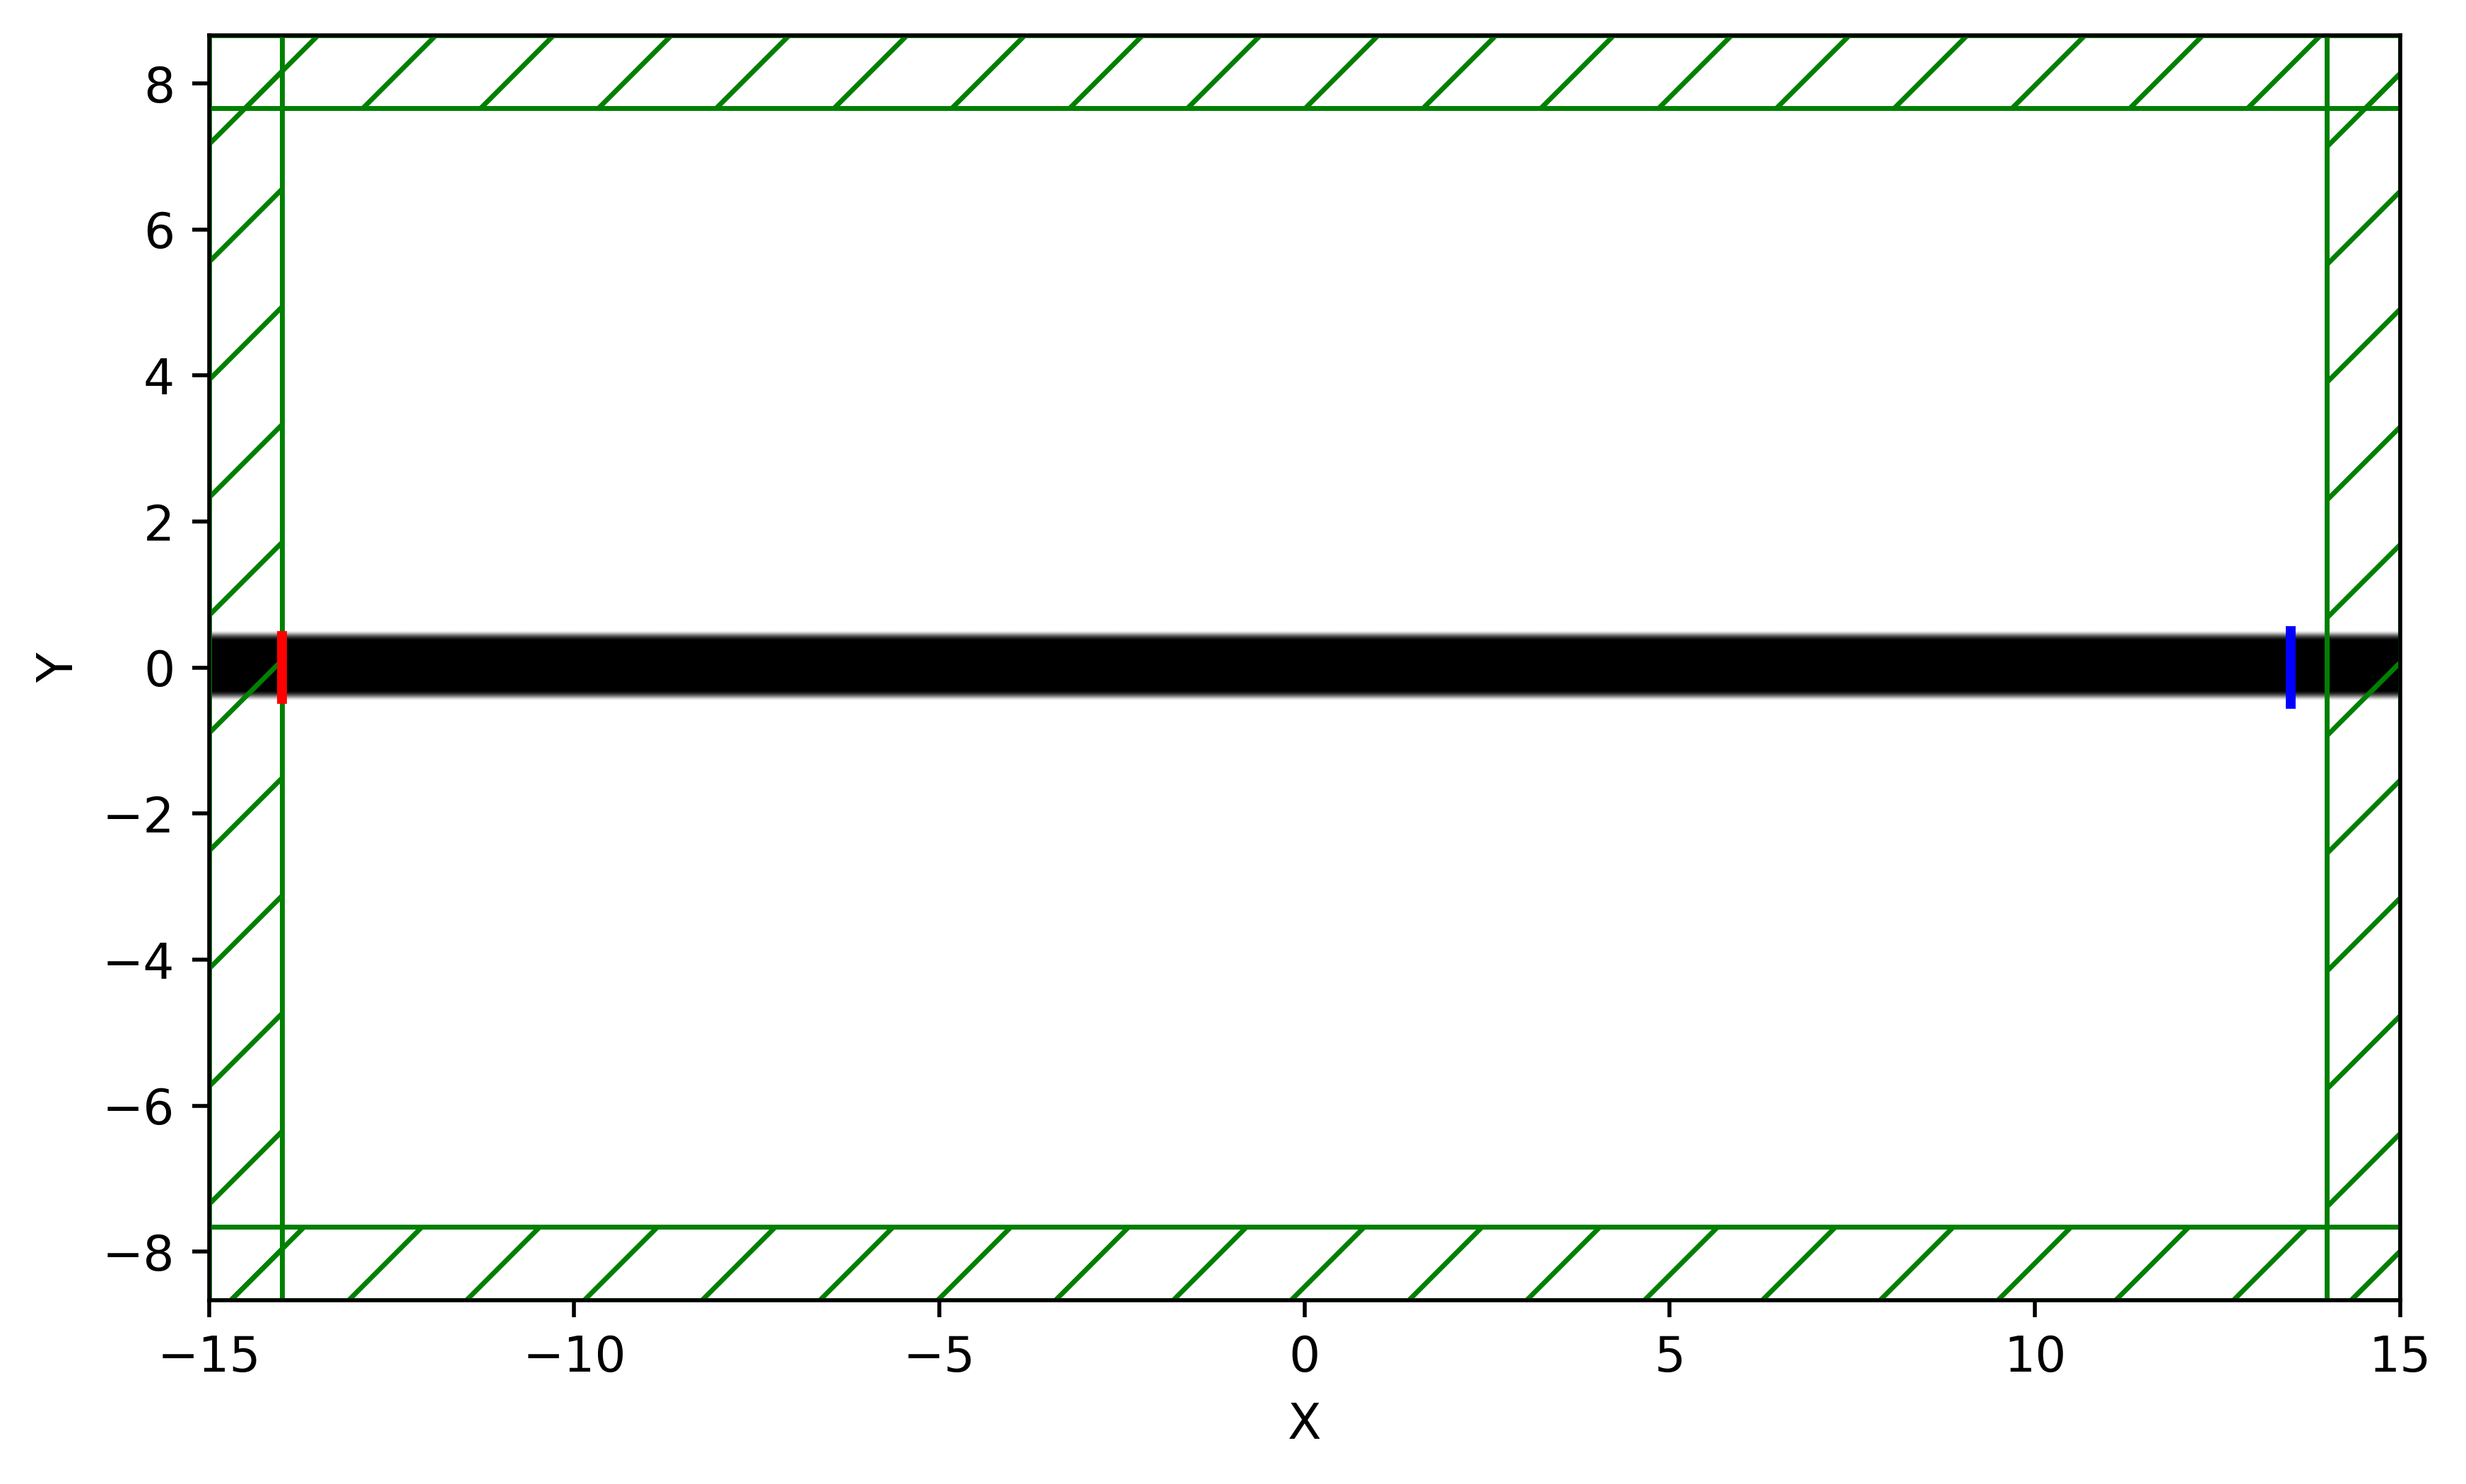

FloatProgress(value=0.0, description='0% done ', max=500.0)

Meep progress: 34.75/500.0 = 7.0% done in 4.0s, 53.6s to go
on time step 1123 (time=35.0938), 0.00356245 s/step
Meep progress: 76.09375/500.0 = 15.2% done in 8.0s, 44.6s to go
on time step 2441 (time=76.2812), 0.00303651 s/step
Meep progress: 116.78125/500.0 = 23.4% done in 12.0s, 39.4s to go
on time step 3741 (time=116.906), 0.00307799 s/step
Meep progress: 157.6875/500.0 = 31.5% done in 16.0s, 34.7s to go
on time step 5058 (time=158.062), 0.00303873 s/step
Meep progress: 195.3125/500.0 = 39.1% done in 20.0s, 31.2s to go
on time step 6260 (time=195.625), 0.00332839 s/step
Meep progress: 238.5625/500.0 = 47.7% done in 24.0s, 26.3s to go
on time step 7646 (time=238.938), 0.00288651 s/step
Meep progress: 279.71875/500.0 = 55.9% done in 28.0s, 22.1s to go
on time step 8960 (time=280), 0.00304501 s/step
Meep progress: 317.625/500.0 = 63.5% done in 32.0s, 18.4s to go
on time step 10180 (time=318.125), 0.00327948 s/step
Meep progress: 361.53125/500.0 = 72.3% done in 36.0s, 13.8s to go
on tim

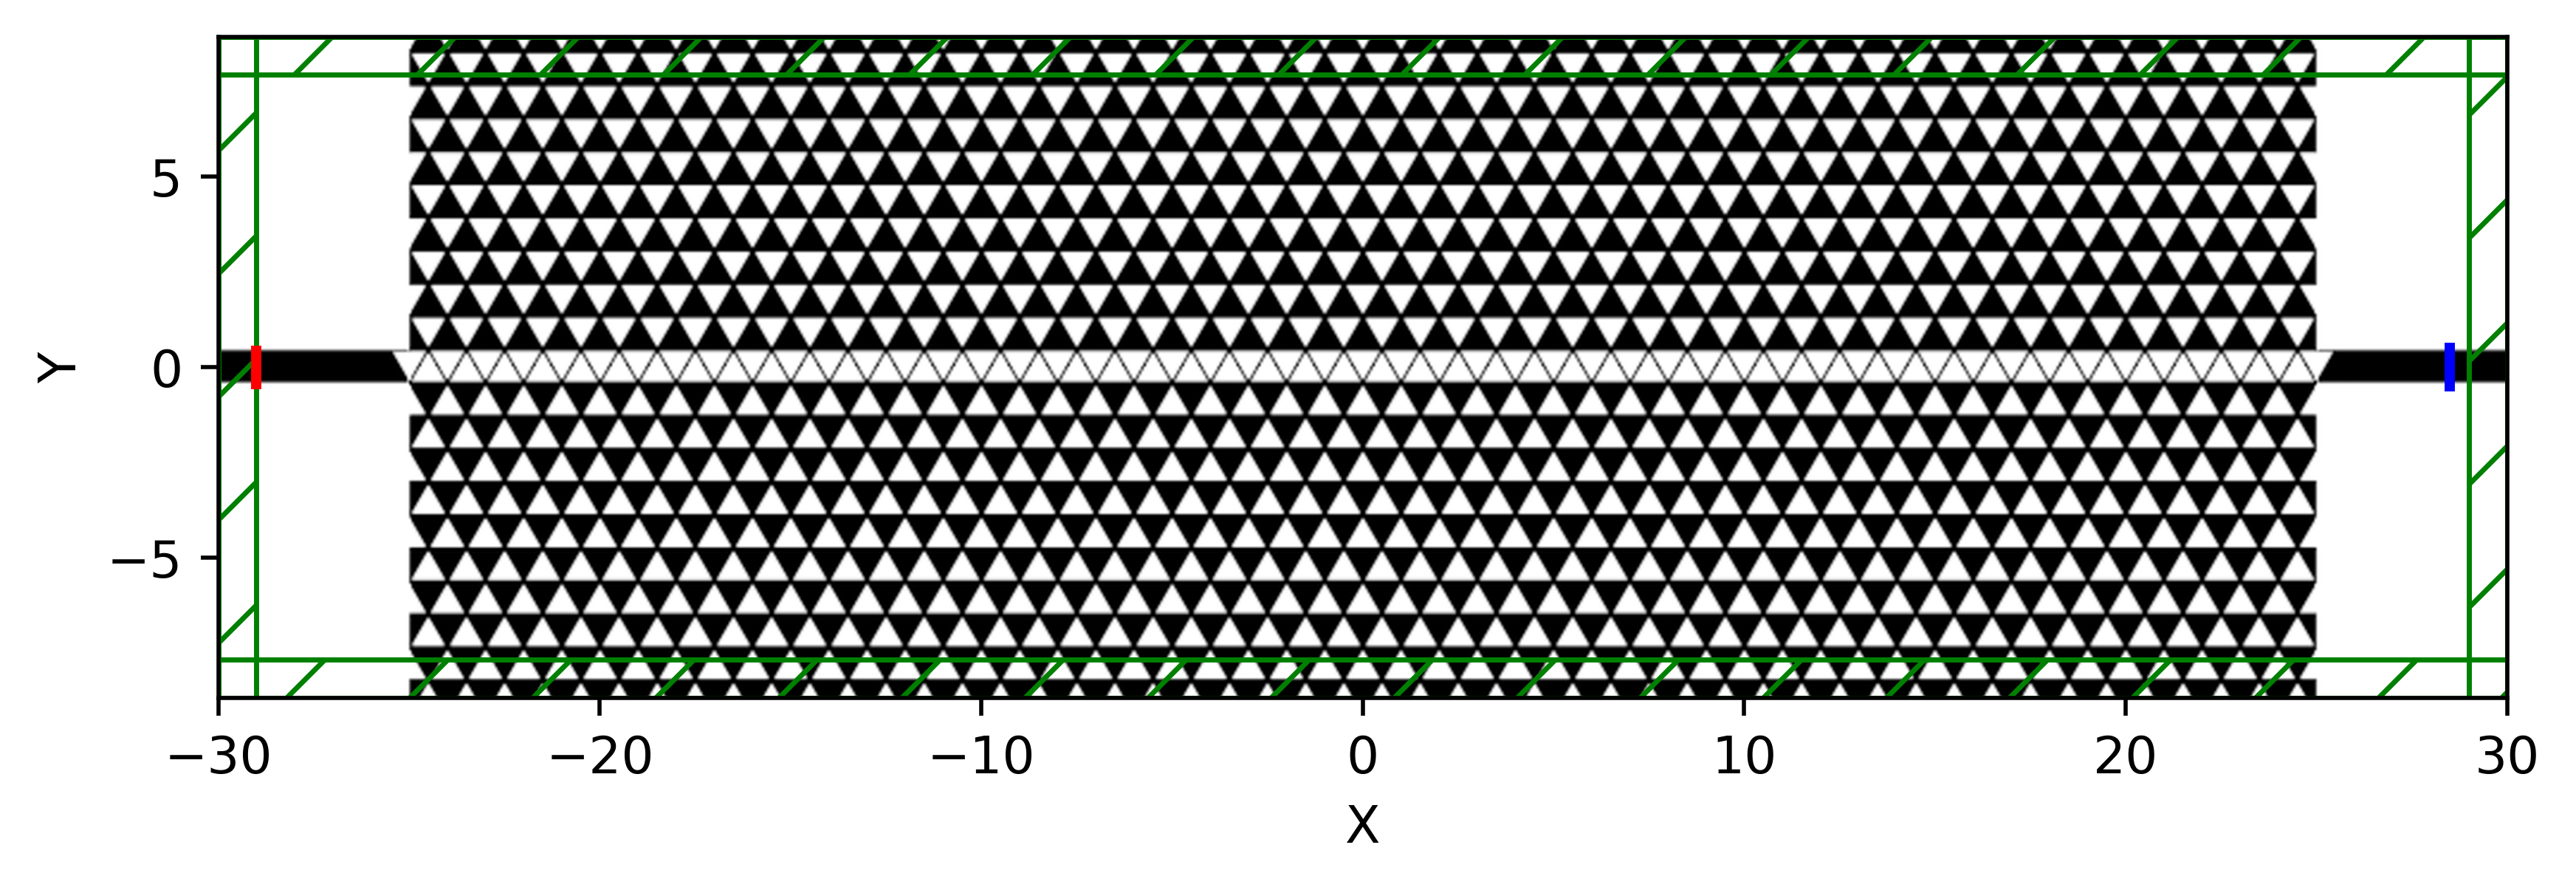

FloatProgress(value=0.0, description='0% done ', max=10000.0)

 time step 219312 (time=6853.5), 0.00755076 s/step
Meep progress: 6869.46875/10000.0 = 68.7% done in 1602.2s, 730.1s to go
on time step 219903 (time=6871.97), 0.00677768 s/step
Meep progress: 6890.3125/10000.0 = 68.9% done in 1606.2s, 724.9s to go
on time step 220591 (time=6893.47), 0.00582045 s/step
Meep progress: 6912.65625/10000.0 = 69.1% done in 1610.2s, 719.1s to go
on time step 221295 (time=6915.47), 0.00568773 s/step
Meep progress: 6931.625/10000.0 = 69.3% done in 1614.2s, 714.5s to go
on time step 221877 (time=6933.66), 0.00687563 s/step
Meep progress: 6953.21875/10000.0 = 69.5% done in 1618.2s, 709.1s to go
on time step 222587 (time=6955.84), 0.00564781 s/step
Meep progress: 6971.84375/10000.0 = 69.7% done in 1622.2s, 704.6s to go
on time step 223168 (time=6974), 0.00688828 s/step
Meep progress: 6988.375/10000.0 = 69.9% done in 1626.2s, 700.8s to go
on time step 223706 (time=6990.81), 0.00744523 s/step
Meep progress: 7003.65625/10000.0 = 70.0% done in 1630.2s, 697.4s to go
on 

In [4]:
freqs_wo, psd_out_wo = phc_trans(PhC = False, lengthPhC = 20, decay_check=10, T_decay=500)
freqs_w,  psd_out_w  = phc_trans(PhC = True, lengthPhC = 50, decay_check=20, T_decay=10000)

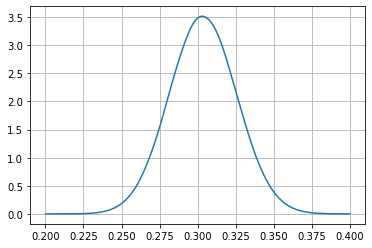

In [5]:
plt.plot(freqs_wo,psd_out_wo)
plt.grid(True)

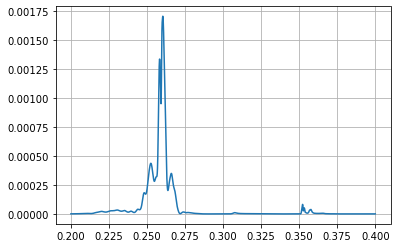

In [6]:
plt.plot(freqs_w,psd_out_w)
plt.grid(True)

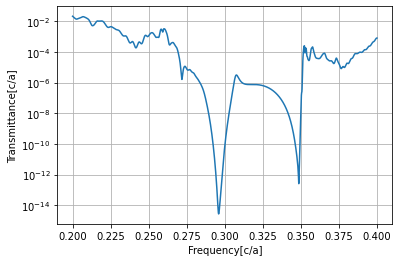

In [7]:
plt.plot(np.array(freqs_w), np.array(psd_out_w)/np.array(psd_out_wo))
plt.xlabel("Frequency[c/a]")
plt.ylabel("Transmittance[c/a]")
plt.yscale('log')
plt.grid(True)

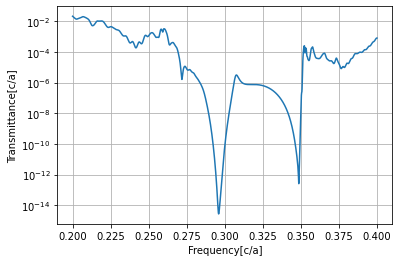

In [8]:
plt.plot(np.array(freqs_w), np.array(psd_out_w)/np.array(psd_out_wo))
plt.xlabel("Frequency[c/a]")
plt.ylabel("Transmittance[c/a]")
plt.yscale('log')
plt.grid(True)

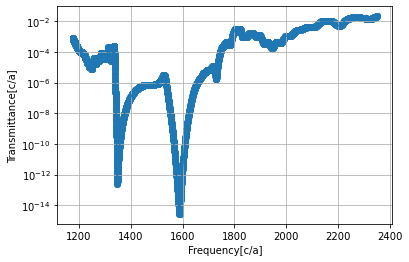

In [9]:
a = 470
c_const = 299792458

freqs = a / np.array(freqs_w)
#freqs
plt.plot(freqs, np.array(psd_out_w)/np.array(psd_out_wo))
plt.scatter(freqs, np.array(psd_out_w)/np.array(psd_out_wo))
plt.xlabel("Frequency[c/a]")
plt.ylabel("Transmittance[c/a]")
#plt.xlim([0.28,0.30])
plt.yscale('log')
plt.grid(True)

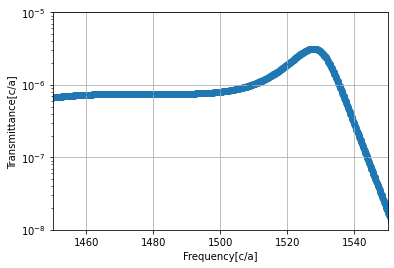

In [15]:
freqs = a / np.array(freqs_w)
#freqs
plt.plot(freqs, np.array(psd_out_w)/np.array(psd_out_wo))
plt.scatter(freqs, np.array(psd_out_w)/np.array(psd_out_wo))
plt.xlabel("Frequency[c/a]")
plt.ylabel("Transmittance[c/a]")
plt.xlim([1450,1550])
plt.yscale('log')
plt.ylim([1e-8,1e-5])
plt.grid(True)

In [15]:
df = pd.DataFrame()
df["wavelength"] = freqs
df["transmittance"] = np.array(psd_out_w)/np.array(psd_out_wo)
df.to_csv("210111_waveguide_VPhCtriangle_bearded_adiabatic_transmittance_d085_km005.csv")


In [16]:
df

,wavelength,transmittance
0,2350.000000,0.035522
1,2345.300000,0.033173
2,2340.618762,0.030877
3,2335.956175,0.028562
4,2331.312127,0.026239
...,...,...
495,1179.728370,0.019919
496,1178.542714,0.020704
497,1177.359438,0.021691
498,1176.178536,0.023108
